#  Image-to-Image Translation with GANs
 

# Outline

This is an excerpt from the Kadenze Training course, Creative Applications of Tensorflow IV - Image-to-Image Translation with GANs.

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- [Introduction](#intro)
- [Training Results](#training_results)
    - [Objective](#training_results_obj)
    - [Training Data](#training_results_data)
    - [CycleGAN Hyperparameters](#training_results_params)
    - [Training Loss](#training_results_loss)
    
- [Test Data Results](#test_results)
<!-- /MarkdownTOC -->

In [1]:
import sys
# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
    import tensorflow.contrib.layers as tfl
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, datasets, dataset_utils
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

Make sure you have started notebook in the same directory as the provided zip file which includes the 'libs' folder and the file 'utils.py' inside of it.  You will NOT be able to complete this assignment unless you restart jupyter notebook inside the directory created by extracting the zip file or cloning the github repo.


<a name="intro"></a>
## Introduction

### CycleGANs
The CycleGAN trains 2 autoencoders using a set of generators and discriminators. It does not require paired translations of data - The input (x) and output (y) pairs do not need to be specified. 

### Generator
There are 3 major components- an encoder, transformer, and decoder.
- Encoder - is composed of a few convolutional layers with stride 2 which will downsample the image with each layer.
- Transformer - Instead of simply having a convolutional layer, we'll have a convolutional layer and then sum together the original output. So it's a sort of residual function of the input which should be learned, residual meaning what's left over. The residual blocks allow the base activation to persist, but then learns a simple addition on top of that layer. This is useful because it ensures the original activation has a path to the output. And similarly, it is useful for backpropagation since the gradient has less chance of exploding or vanishing, as they typically can do in very deep networks
- Decoder - This part of the model is going to do the opposite of our Encoder. It will reconstruct or upsample the Transformer's output into images.

### Discriminator
This network will take as input an image and then output a single value. In the case of a true image, it should output 1, and in the case of a false image, it should output 0. For the generator, we want the opposite to be true. In any case, the discriminator should saturate at 0 or 1, so will need a sigmoid as its final activation. It doesn't actually reduce down the image to a single value, but instead will reduce down the length x width pixel image to a spatial map with 1 channel as output. The resulting map effectively has individual discriminators which we average together to get the final result.

<a name="training_results"></a>
# Training Results

<a name="training_results_obj"></a>
## Objective

The stock CycleGAN model was used for this exercise. The objective of the experiment was to find out if the CycleGAN had an ability to generate images of resturant plated dishes based on sketchings. 

The use case - a method by which chefs or home cooks use the model to generate ideas of new dishes, or more creative ways of plating up a dish, based on rough sketches or doodles. It could help overcome creative blocks, or allow the user to think outside the box.

<a name="training_results_data"></a>
## Training Data
The input images were sketch renderings of restaurant plated dishes and the output was real images of the plated dishes.

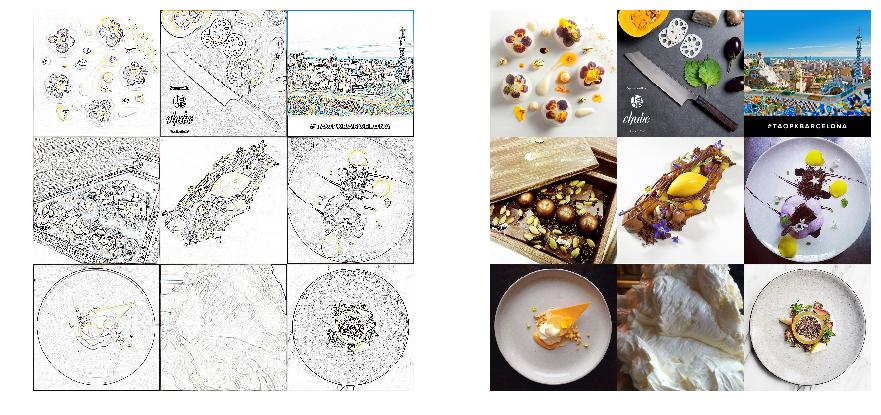

In [48]:
x = plt.imread('imgs/results/test_xs.png')
y = plt.imread('imgs/results/test_ys.png')
f, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(x)
ax[1].imshow(y)

<a name="training_results_params"></a>
## CycleGAN Configuration

The network was configured according to the following paper - https://arxiv.org/abs/1703.10593
### Generator
#### Encoder
- Padding layer- tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
- Convolution Layer 1- Kernel: 7x7, Stride: 1, Leaky RELU: 0.2, Filters: 32, normaliser: instance_norm
- Convolution Layer 2- Kernel: 3x3, Stride: 2, Leaky RELU: 0.2, Filters: 64, normaliser: instance_norm
- Convolution Layer 3- Kernel: 3x3, Stride: 2, Leaky RELU: 0.2, Filters: 128, normaliser: instance_norm

#### Transformer
The below layers are created 6 times over.
- Padding layer 1-  tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
- Residual Convolution Layer 1- Kernel: 3x3, Stride: 1, Leaky RELU: 0.2, Filters: 128
- Padding layer 2-  tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
- Residual Convolution Layer 2- Kernel: 3x3, Stride: 1, Leaky RELU: 0.2, Filters: 128
- Add layer: input to Transformer + output of Residual Convolution Layer 2

#### Decoder
The Decoder is the Encoder network but in reverse order.

### Discriminator
- Convolution Layer 1- Kernel: 4x4, Stride: 2, Leaky RELU: 0.2, Filters: 64, normaliser: instance_norm
- Convolution Layer 2- Kernel: 4x4, Stride: 2, Leaky RELU: 0.2, Filters: 128,normaliser: instance_norm
- Convolution Layer 3- Kernel: 4x4, Stride: 2, Leaky RELU: 0.2, Filters: 256, normaliser: instance_norm
- Convolution Layer 4- Kernel: 4x4, Stride: 1, Leaky RELU: 0.2, Filters: 512, normaliser: instance_norm
- Convolution Layer 5- Kernel: 4x4, Stride: 1, Sigmoid, Filters: 1, normaliser: instance_norm

### Configuration
We have a Generator of fake images for both the input and output real images:
- X fake images = Generator(Y real images)
- Y fake images = Generator(X real images)

We also have a Generator of Cycle images for both the input and output fake images:
- X cycle images = Generator(Y fake images)
- Y cycle images = Generator(X fake images)

The Discriminator configurations are as follow:
- Discriminator X real images = Discriminator(X real images)
- Discriminator Y real images = Discriminator(Y real images)
- Discriminator X fake images = Discriminator(X fake images)
- Discriminator Y fake images = Discriminator(Y fake images)

And the loss functions:
- l1 = 10.0
- loss_cycle = tf.reduce_mean(l1 * tf.abs(X_real - X_cycle)) + tf.reduce_mean(l1 * tf.abs(Y_real - Y_cycle))
- loss_G_xy = tf.reduce_mean(tf.square(D_Y_fake - 1.0)) + loss_cycle
- loss_G_yx = tf.reduce_mean(tf.square(D_X_fake - 1.0)) + loss_cycle


<a name="training_results_loss"></a>
## Training Loss

### Model Convergence

The network was trained for approximately 30,000 iterations in the 2 stages. For some reason, my terminal session had timed out which caused the training to stop.

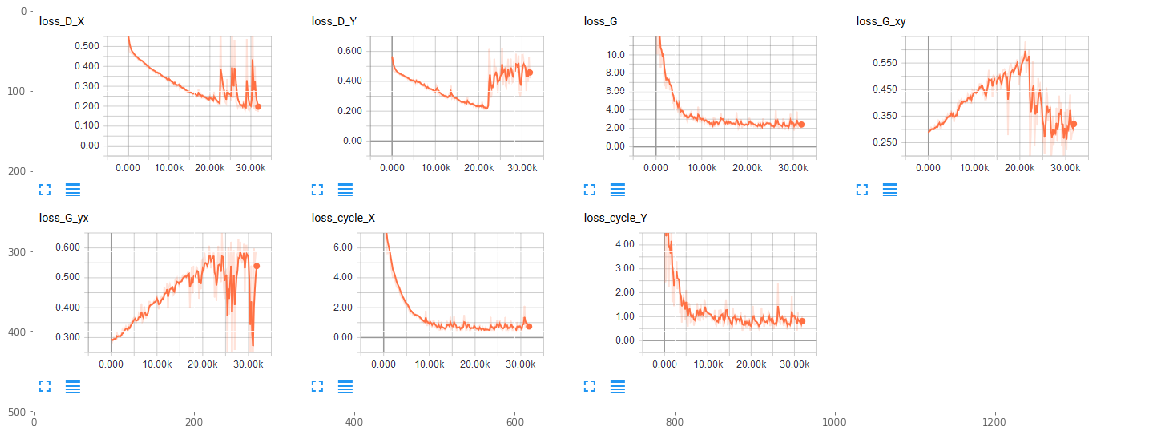

In [49]:
loss_plot = plt.imread('imgs/results/tb_training1.png')
f, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.imshow(loss_plot)

As observed in the above plots:
- The Discriminator Y loss had progressively reduced until about the 25,000th iteration, where there was a jump and plateau in the loss value
- It lines up with the Generator Y loss (that generates fake output images), where there is a progressive increase and then decrease at the same iteration count.
- It can be hypothesized that the Discrminator was doing a fairly competent job at detecting fake images, until the 25,000th iteration, where the Generator was able to create fake images that started to trick the Discriminator.
- This is an interesting phenomenon, as the model did not show any signs of Generator loss improvements, and then abruptly converges at the 25,000th iteration.

Below shows a comparision between a real Y image, and a fake Y image at the 30,000th iteration:

(-0.5, 346.5, 438.5, -0.5)

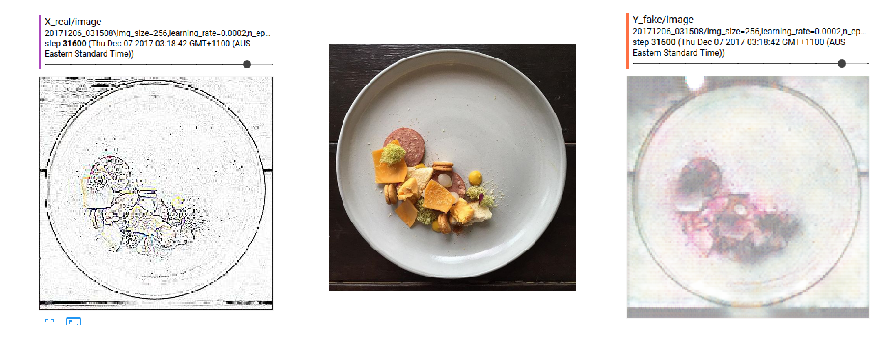

In [53]:
x_real = plt.imread('imgs/results/x_real1.png')
y_real = plt.imread('imgs/results/y_real1.jpg')
y_fake = plt.imread('imgs/results/y_fake1.png')
f, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(x_real)
ax[0].axis('off')
ax[1].imshow(y_real)
ax[1].axis('off')
ax[2].imshow(y_fake)
ax[2].axis('off')

Not too shabby for 30,000 iterations of training. We will train the network further to see if we can achieve any improvements. You might argue that the colours do not match on the 2 images. But that is not the objective of a CycleGAN as we are not feeding paired images into the network. The objective in an intuitive sense, is for the network to take two collections of images and find the mapping between them.

The model training was progressed for another 20,000 iterations. There wasn't much further improvement to the loss. At this stage, I had spent quite enough money with AWS and waited quite enough time for the model to converge.

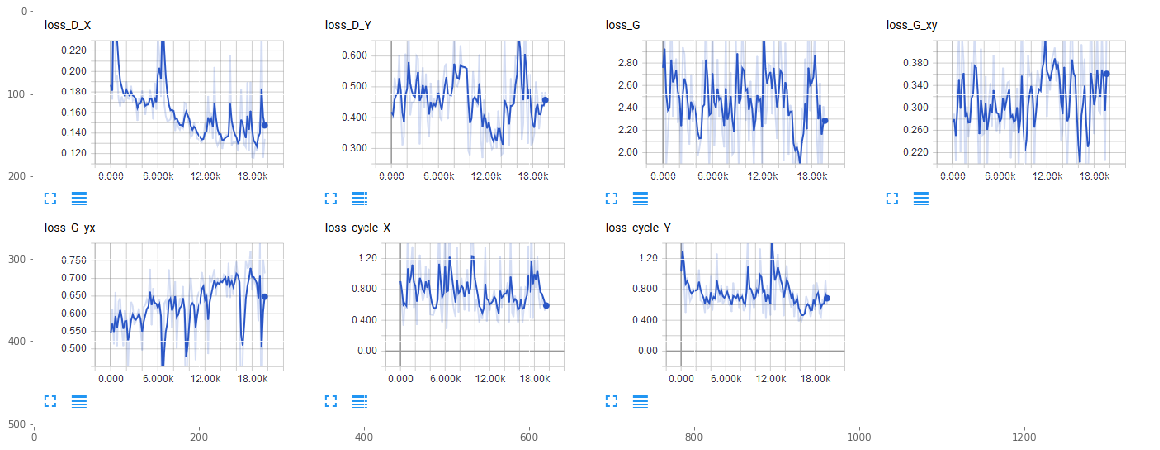

In [51]:
loss_plot = plt.imread('imgs/results/tb_training2.png')
f, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.imshow(loss_plot)

(-0.5, 361.5, 452.5, -0.5)

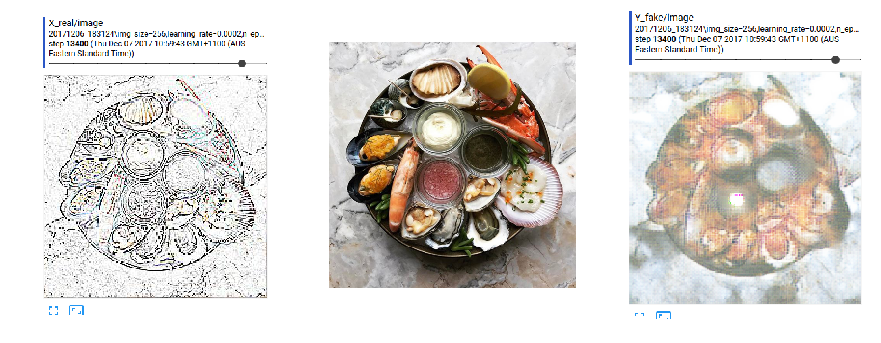

In [54]:
x_real = plt.imread('imgs/results/x_real2.png')
y_real = plt.imread('imgs/results/y_real2.jpg')
y_fake = plt.imread('imgs/results/y_fake2.png')
f, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(x_real)
ax[0].axis('off')
ax[1].imshow(y_real)
ax[1].axis('off')
ax[2].imshow(y_fake)
ax[2].axis('off')

## Fake Image Reconstruction
Below is a time lapse of the fake image reconstruction over the course of training the network:

In [59]:
import imageio
directory = 'imgs/20171206_031508/'
files_X = [os.path.join(directory, file_i) for file_i in os.listdir(directory) if 'reconXFake' in file_i]
image_X = [plt.imread(f) for f in files_X]
imageio.mimsave('imgs/results/reconX.gif', image_X)

C:\Users\eutan\Anaconda3\lib\site-packages\imageio\core\util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [60]:
files_Y = [os.path.join(directory, file_i) for file_i in os.listdir(directory) if 'reconYFake' in file_i]
image_Y = [plt.imread(f) for f in files_Y]
imageio.mimsave('imgs/results/reconY.gif', image_Y)

C:\Users\eutan\Anaconda3\lib\site-packages\imageio\core\util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [61]:
ipyd.Image(url='imgs/results/reconX.gif?i={}'.format(
        np.random.rand()), height=400, width=400)


In [62]:
ipyd.Image(url='imgs/results/reconY.gif?i={}'.format(
        np.random.rand()), height=400, width=400)

<a name="test_results"></a>
## Test Data Results

So what happens when we present new data to the network?

Restoring existing model
INFO:tensorflow:Restoring parameters from cycle_gan/final/model.ckpt
Y_fake:  (1, 256, 256, 3)


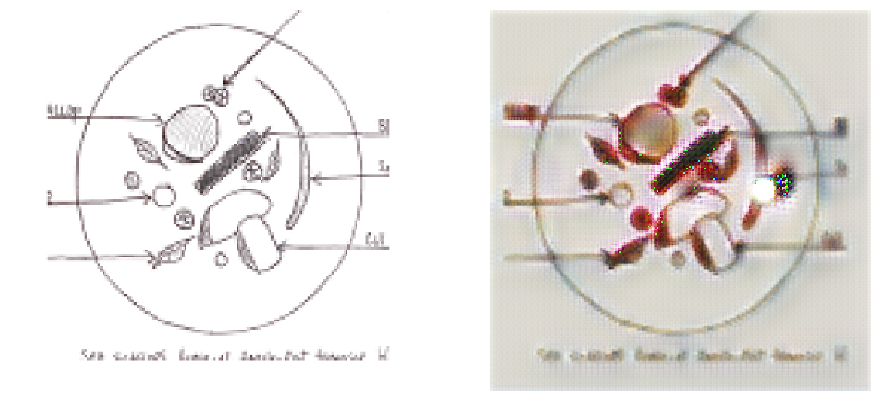

In [76]:
from libs.cyclegan import cycle_gan
import tensorflow as tf

img_size = 256
ckpt_name = "cycle_gan/final/model.ckpt"
X = plt.imread('imgs/results/test1.png')
X  = X[:, :, :3]
X = np.array([X])

with tf.Graph().as_default(), tf.Session() as sess:
    # Load the network
    net = cycle_gan(img_size=img_size)
    saver = tf.train.Saver()
    if os.path.exists(ckpt_name + '.index') or os.path.exists(ckpt_name):
        print("Restoring existing model")
        saver.restore(sess, ckpt_name)
    Y_fake = sess.run(net['Y_fake'], feed_dict={net['X_real']: X})
    print("Y_fake: ", Y_fake.shape)
    f, ax = plt.subplots(1, 2, figsize=(15,15))
    ax[0].axis('off')
    ax[0].imshow(X[0])
    ax[1].axis('off')
    ax[1].imshow(Y_fake[0])
    
